<h1>Drive Mounting</h1>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


<h1>Installing necessary packages</h1>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,cv2,glob
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,Flatten,Dense
from PIL import Image
from numpy import asarray
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import  plot_model
from zipfile import ZipFile
from shutil import copyfile
from tensorflow.keras import layers,Sequential,optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<h1>Data Extraction</h1>

In [3]:
#Path of the jupyter file
path=os.getcwd()
path

'/content'

In [4]:
#Extracting the dataset
with ZipFile(os.path.join(path ,'/gdrive/MyDrive/Vivek/Face_Recognition/Notebook/105_classes_pins_dataset.zip'),'r') as zipobject:
  zipobject.extractall()

<h1>Train Test Split</h1>
<ul>
    <li>We are going to split train and test images into different folder.</li>
</ul>

In [5]:
#Splitting the data into train & test by making seperate directories & storing the data respectively.
train_dir = os.path.join(path,'train')        
test_dir = os.path.join(path,'test')

#Creating directory for test & train images
os.makedirs(train_dir, exist_ok=True)  
os.makedirs(test_dir, exist_ok=True) 

In [6]:
#Number of classes in dataset
dir_list=os.listdir(os.path.join(path ,'105_classes_pins_dataset'))
print('The Number of Classes in the Dataset is:{}'.format(len(dir_list)))

The Number of Classes in the Dataset is:105


**Split the unzip data with given percent and store them in train & test directory.**

In [7]:
#Defining the split percent for train and test respectively. 
train_ratio=0.75
test_ratio=0.25

#File path of dataset
source_dir = os.path.join(path ,'105_classes_pins_dataset')        

#list of all file present in the specified path
dir_list = os.listdir(source_dir)

for folder in dir_list:
    
    #File path
    data_dir = os.listdir(os.path.join(source_dir,folder))
    
    ##Modify a sequence in-place by shuffling its contents
    np.random.shuffle(data_dir)
    
    #creating folder for train image set
    os.makedirs(os.path.join(train_dir , folder), exist_ok=True)
    
    #creating folder for test image set
    os.makedirs(os.path.join(test_dir , folder), exist_ok=True)
    
    #Defining test ratio for train and test
    train_data = data_dir[:int(len(data_dir)*train_ratio+1)] 
    test_data = data_dir[-int(len(data_dir)*test_ratio):]
    
    #copying image file from dataset to train set
    for image in train_data:
        copyfile(os.path.join(source_dir,folder,image) , os.path.join(train_dir,folder,image)) 
    
    #copying image file from dataset to test set
    for image in test_data:
       copyfile(os.path.join(source_dir,folder,image) , os.path.join(test_dir,folder,image))  
    

<h2>Split Data Check</h2>

The Number of Classes in the Training Set:105
The Number Of Classes in the Testing Set:105

For Verification of the Split.....
The Number of Examples in the Class='pins_Leonardo DiCaprio' in the Dataset Directory:237
The Number of Examples in the Class='pins_Leonardo DiCaprio' in the Train Directory:178
The Number of Examples in the Class='pins_Leonardo DiCaprio' in the Test Directory:59


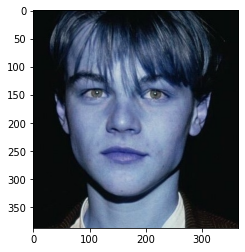

In [8]:
print("The Number of Classes in the Training Set:{}".format(len(os.listdir(train_dir))))
print("The Number Of Classes in the Testing Set:{}".format(len(os.listdir(test_dir))))
print('\nFor Verification of the Split.....')
print("The Number of Examples in the Class='pins_Leonardo DiCaprio' in the Dataset Directory:{}".format(len(os.listdir(os.path.join(source_dir,'pins_Leonardo DiCaprio')))))
print("The Number of Examples in the Class='pins_Leonardo DiCaprio' in the Train Directory:{}".format(len(os.listdir(os.path.join(train_dir,'pins_Leonardo DiCaprio')))))
print("The Number of Examples in the Class='pins_Leonardo DiCaprio' in the Test Directory:{}".format(len(os.listdir(os.path.join(test_dir,'pins_Leonardo DiCaprio')))))
path =cv2.imread('105_classes_pins_dataset/pins_Leonardo DiCaprio/Leonardo DiCaprio207_2570.jpg')
plt.imshow(path)
plt.show()

<h1>Data Augmentation</h1>
<ul>
    <li>Data augmentation is the process of modifying, or “augmenting” a dataset with additional data.</li>
    <li>Techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.</li>
</ul>

In [9]:
rows=224  #Number of Pixels in the Rows
cols=224  #Number of Pixels in Columns

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)

#Iaugment images in real-time while model is still training
test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images using train_datagen generator
train_generator=train_datagen.flow_from_directory(train_dir,
                                                  target_size=(rows,cols),
                                                  class_mode='categorical')

# Flow validation images using test_datagen generator
test_generator=test_datagen.flow_from_directory(test_dir,
                                                target_size=(rows,cols),
                                                class_mode='categorical')

Found 13212 images belonging to 105 classes.
Found 4340 images belonging to 105 classes.


<h1>Import The Base model</h1>
<ul>
    <h2>MobileNetV2</h2><br>
    <li>MobileNet-v2 is a convolutional neural network that is 53 layers deep.</li>
    <li>The pretrained network can classify images into 1000 object categories.It is a very effective feature extractor for object detection and segmentation.</li>
    <li>It is based on an inverted residual structure where the residual connections are between the bottleneck layers.</li>
</ul>

In [10]:
#Defining Pre-train model
trained_model=MobileNetV2(input_shape=(rows,cols,3),           
                    include_top=False,
                    weights='imagenet')   

#Un-Freeze all the pretrained layers of 'MobileNetV2 for Training.
trained_model.trainable=True

#model architecture
trained_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

<h1>Callbacks</h1>
<lu><li>Callbacks are commands you can define that execute in response to a specific modeling action, such as opening a model or stopping a simulation.</li></ul>

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
        print("\nCongralutions Model has reached 98% accuracy.")
        self.model.stop_training = True
callbacks=myCallback()

<h1>CNN Model</h1>
<ul><li><u>Activation Function:</u> A function that is added into an artificial neural network in order to help the network learn complex patterns in the data.Most used function are Sigmoid, ReLU, Leaky ReLU, tanh, Linear, Softmax and etc. </li>
<li>In our case we will be use 'Softmax' activation function.softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.As model has 105 classes as output.</li>
<li><u>Loss Function:</u> It quantifies the difference between the expected outcome and the outcome produced by the machine learning model.Regression Loss Function,Mean Squared Error,Mean Squared Logarithmic Error Loss.
Mean Absolute Error Loss,Binary Classification Loss Function,Binary Cross Entropy Loss.</li>
<li>We will use Categorical crossentropy,it is used in multi-class classification tasks. These are tasks where an example can only belong to one out of many possible categories(105 classes), and the model must decide which one.</li>
<li><u>Optimizer:</u> An optimizer is a function or an algorithm that modifies the attributes of the neural network, such as weights and learning rate. Thus, it helps in reducing the overall loss and improve the accuracy.Types of optimizer are Gradient Descent,Stochastic Gradient Descent,Adagrad,Adadelta,RMSprop,Adam.</li>
<li>We will use Adam optimizer because the results are generally better than every other optimization algorithms, have faster computation time, can handle sparse gradients on noisy problems and require fewer parameters for tuning. Because of all that, Adam is recommended as the default optimizer for most of the applications</li>
</ul>

In [12]:
#takes a tensor of size (input width) x (input height) x (input channels) and computes the average value of all 
#  values across the entire (input width) x (input height) matrix for each of the (input channels).
x = tf.keras.layers.GlobalAveragePooling2D()(trained_model.output)

#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.5)(x)

# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(105,activation='softmax')(x)

model = tf.keras.Model(trained_model.input,x) 

#Compileing model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#Summary of the model.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

<h1>Model Execution</h1>

In [13]:
#fitting model
result=model.fit(train_generator,
                 validation_data=test_generator,
                 epochs=100,
                 callbacks=[callbacks],
                 verbose=1)

Epoch 1/100
413/413 [==============================] - 196s 436ms/step - loss: 4.4894 - accuracy: 0.0425 - val_loss: 4.4374 - val_accuracy: 0.0532
Epoch 2/100
413/413 [==============================] - 177s 428ms/step - loss: 3.4423 - accuracy: 0.1757 - val_loss: 3.4095 - val_accuracy: 0.1703
Epoch 3/100
413/413 [==============================] - 176s 427ms/step - loss: 2.5022 - accuracy: 0.3555 - val_loss: 2.5093 - val_accuracy: 0.3459
Epoch 4/100
413/413 [==============================] - 176s 427ms/step - loss: 1.8576 - accuracy: 0.5070 - val_loss: 2.0351 - val_accuracy: 0.4634
Epoch 5/100
413/413 [==============================] - 176s 427ms/step - loss: 1.4119 - accuracy: 0.6141 - val_loss: 1.6700 - val_accuracy: 0.5442
Epoch 6/100
413/413 [==============================] - 176s 427ms/step - loss: 1.1162 - accuracy: 0.6937 - val_loss: 1.3457 - val_accuracy: 0.6389
Epoch 7/100
413/413 [==============================] - 177s 428ms/step - loss: 0.9011 - accuracy: 0.7502 - val_loss: 1

In [14]:
# Save model for later use
tf.keras.models.save_model(model,'/gdrive/MyDrive/Vivek/Face_Recognition/model.h5')

#Model Evalution

In [15]:
##result.history

#Model Testing 

In [16]:
from tensorflow.keras.models import load_model

#Loading model file
df = load_model('/gdrive/MyDrive/Vivek/Face_Recognition/Notebook/model.h5')

In [17]:
df.save_weights('my_model_weights.h5')

In [ ]:
#path of the image
path="/content/test/pins_Chris Evans/Chris Evans135_1134.jpg"
img=path

classes=train_generator.class_indices
class_names=list(classes.keys())   #List of the class names
img = tf.keras.preprocessing.image.load_img(
    path, target_size=(rows, cols)
)

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array=img_array/255.


The Person in the Image is Chris Evans .


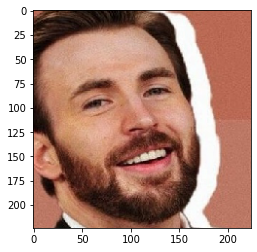

In [ ]:
score = df.predict(img_array)


plt.imshow(img)
print("The Person in the Image is {} .".format(class_names[np.argmax(score)][5:].title()))